# Import appropriate modules

In [438]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants
from scipy.sparse import csgraph

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

import mpl_interactions.ipyplot as iplt
from mpl_interactions.controller import Controls

from functools import partial

import itertools

from tabulate import tabulate

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

# Define 'global' Constants

In [137]:
H_BAR = scipy.constants.hbar

I1 = Rb87Cs133["I1"]
I2 = Rb87Cs133["I2"]
D_0 = Rb87Cs133["d0"]
N_MAX=2

I = 0 #W/m^2
E = 0 #V/m

B_MIN_GAUSS = 0.001
B_MAX_GAUSS = 1000
B_STEPS = 500
PULSE_TIME_US = 500

settings_string = f'NMax{N_MAX}BMin{B_MIN_GAUSS}BMax{B_MAX_GAUSS}BSteps{B_STEPS}PTime{PULSE_TIME_US}'
print(settings_string)

GAUSS = 1e-4 # T
B_MIN = B_MIN_GAUSS * GAUSS # T
B_MAX = B_MAX_GAUSS * GAUSS # T
PULSE_TIME = PULSE_TIME_US * 1e-6 # s

B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T 

NMax2BMin0.001BMax1000BSteps500PTime500


In [138]:
data = np.load(f'../precomputed/{settings_string}.npz')
ENERGIES = data['energies']
N_STATES = len(ENERGIES[0])
STATES = data['states']
LABELS=data['labels']
MAGNETIC_MOMENTS=data['magnetic_moments'] 
COUPLINGS_ZERO=data['coupling_matrix_zero']
COUPLINGS_MINUS=data['coupling_matrix_minus']
COUPLINGS_PLUS=data['coupling_matrix_plus']
COUPLINGS = COUPLINGS_ZERO+COUPLINGS_MINUS+COUPLINGS_PLUS
POLARISED_COUPLING = [COUPLINGS_ZERO,COUPLINGS_PLUS,COUPLINGS_MINUS]
UNPOLARISED_PAIR_FIDELITIES = data['unpolarised_pair_fidelities']
UNPOLARISED_PAIR_FIDELITIES = UNPOLARISED_PAIR_FIDELITIES + UNPOLARISED_PAIR_FIDELITIES.transpose(1,0,2)
POLARISED_PAIR_FIDELITIES=data['polarised_pair_fidelities']
POLARISED_PAIR_FIDELITIES = POLARISED_PAIR_FIDELITIES + POLARISED_PAIR_FIDELITIES.transpose(1,0,2)

# Helper Functions

In [150]:
def label_to_state_no(N,MF,k):
    return np.where((LABELS[:, 0] == N) & (LABELS[:, 1] == MF) & (LABELS[:, 2] == k))[0][0]

def state_no_to_uncoupled_label(state_no):
    i=0
    I1d = round(2*I1)
    I2d = round(2*I2)
    for n in range(0, N_MAX + 1):
        for mn in range(n,-(n+1),-1):
            for mi1 in range(I1d,-I1d-1,-2):
                for mi2 in range(I2d,-I2d-1,-2):
                    if i == state_no:
                        return (n,mn,mi1/2,mi2/2)
                    i+=1

def label_degeneracy(N,MF):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    I1d=round(2*I1)
    I2d=round(2*I2)
    for MN in range(-N,N+1):
        for M_I1d in range(-I1d,I1d+1,2):
            for M_I2d in range(-I2d,I2d+1,2):
                if 2*MN+M_I1d+M_I2d == 2*MF:
                    d+=1
    return d

def reachable_above_from(N,MF):
    sigma_plus_reachable = [(N+1,MF-1,i) for i in range(label_degeneracy(N+1,MF-1))]
    pi_reachable = [(N+1,MF,i) for i in range(label_degeneracy(N+1,MF))]
    sigma_minus_reachable = [(N+1,MF+1,i) for i in range(label_degeneracy(N+1,MF+1))]
    return (sigma_plus_reachable + pi_reachable + sigma_minus_reachable)

def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

def trio_transfer_efficiency(state1_label,state2_label,state3_label,bi,pulse_time=0.0001):
    state1i = label_to_state_no(*state1_label)
    state2i = label_to_state_no(*state2_label)
    state3i = label_to_state_no(*state3_label)
    
    P = state1_label[1] - state2_label[1]
    COUPLING = COUPLINGS[P]
    
    g = np.abs(COUPLING[bi, state1i, state3i]/COUPLING[bi, state1i, state2i])
    k = np.abs(((ENERGIES[bi, state3i] - ENERGIES[bi, state2i]) / scipy.constants.h) / (1/pulse_time))
    sub_transfered = twice_average_fidelity(k,g)
    
    return sub_transfered

def transfer_efficiency(state1_label, state2_label,bi,pulse_time=0.0001):
    transfered = 1
    
    state1i = label_to_state_no(*state1_label)
    state2i = label_to_state_no(*state2_label)

    P = (state1_label[1] - state2_label[1])*(state2_label[0] - state1_label[0])
    this_coupling = COUPLINGS#[P]
    
    for state3i in range(N_STATES):
        if state3i == state1i or state3i == state2i:
            continue
        g = np.abs(this_coupling[bi, state1i, state3i]/this_coupling[bi, state1i, state2i])
        k = np.abs(((ENERGIES[bi, state3i] - ENERGIES[bi, state2i]) / scipy.constants.h) / (1/pulse_time))
        sub_transfered = twice_average_fidelity(k,g)
        transfered *= sub_transfered
        
    return transfered

def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

# Optimise 2-level

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


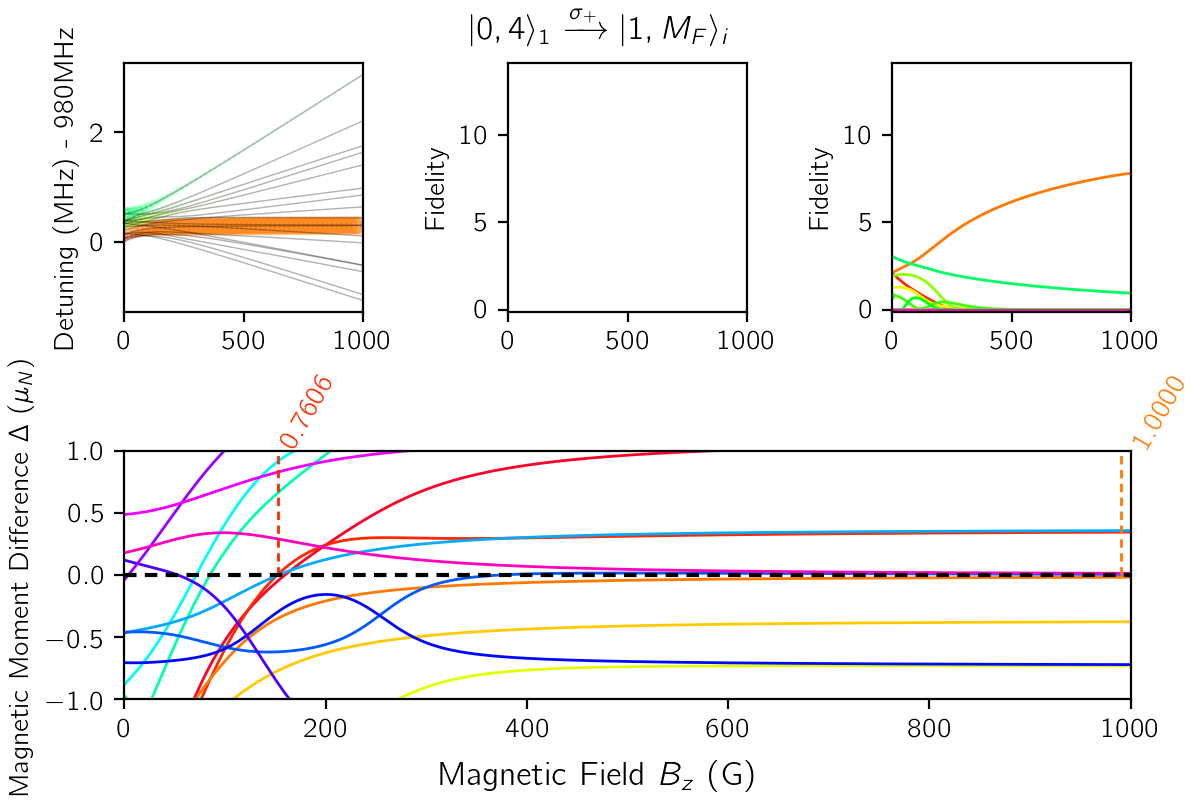

In [598]:
polarisation = 1             # Polarisation: -1,0,1,None
initial_state_label = (0,4,1)   # Which state to go from
focus_state_label = (1,4,2)     # Which state to highlight
desired_pulse_time = 100*1e-6   # What desired pulse time (s)
dynamic_range = 14               # What Dynamic range to use for Fidelity
#################################

if polarisation is None:
    coupling = COUPLINGS
    polarisation_text = '\pi/\sigma_\pm'
else:
    coupling = POLARISED_COUPLING[polarisation]
    polarisation_text = ['\pi','\sigma_+','\pi/\sigma_\pm','\sigma_-'][polarisation]

initial_state_index = label_to_state_no(*initial_state_label)
focus_state_index = label_to_state_no(*focus_state_label)

accessible_state_labels = reachable_above_from(initial_state_label[0],initial_state_label[1])
accessible_state_indices = [label_to_state_no(*label) for label in accessible_state_labels]
state_cmap = plt.cm.gist_rainbow(np.linspace(0,1,len(accessible_state_labels)))

fig = plt.figure(constrained_layout=True,figsize=(6,4))

gs = GridSpec(2, 3, figure=fig)
axl = fig.add_subplot(gs[0, 0])
axm = fig.add_subplot(gs[0, 1])
axr = fig.add_subplot(gs[0, 2])
axb = fig.add_subplot(gs[1, :])

fig.suptitle(r'$|{},{}\rangle_{} \xrightarrow{{{}}} |1,M_F\rangle_i $'.format(*initial_state_label, polarisation_text))

axl.set_xlim(0,B_MAX/GAUSS)
axm.set_xlim(0,B_MAX/GAUSS)
axr.set_xlim(0,B_MAX/GAUSS)

axm.set_ylim(-0.1,dynamic_range+0.1)
axr.set_ylim(-0.1,dynamic_range+0.1)

axl.set_ylabel("Detuning (MHz) - 980MHz")
axm.set_ylabel("Fidelity")
axr.set_ylabel("Fidelity")
fig.supxlabel('Magnetic Field $B_z$ (G)')

# Left zeeman plot
for i, state_index in enumerate(accessible_state_indices):
    this_colour = state_cmap[i]
    det = ((ENERGIES[:, state_index] - ENERGIES[:, initial_state_index]) / scipy.constants.h)
    absg = np.abs(coupling[:, initial_state_index, state_index])
    axl.scatter(B[::10]/GAUSS, det[::10]/1e6-980, color=this_colour, edgecolors=None, alpha=absg[::10]**0.5*0.5, s=absg[::10] ** 2 * 100, zorder=2)    
    axl.plot(B/GAUSS,det/1e6-980,color='k',linewidth=0.5,zorder=3,alpha=0.3)
    
# Middle single state plot
# transfered = np.ones(B_STEPS)
# for off_res_index in range(N_STATES):
#     if off_res_index == initial_state_index or off_res_index == focus_state_index:
#         continue
#     this_colour=state_cmap[accessible_state_indices.index(off_res_index)] if off_res_index in accessible_state_indices else 'black'
#     for (a,b) in [(initial_state_index,focus_state_index),(focus_state_index,initial_state_index)]:
#         k = np.abs((ENERGIES[:, off_res_index] - ENERGIES[:, b]) * desired_pulse_time / scipy.constants.h)
#         g = np.abs(coupling[:, a, off_res_index]/coupling[:, a, b])
#         sub_transfered = twice_average_fidelity(k,g)
#         axm.plot(B/GAUSS,fidelity(sub_transfered, dynamic_range),c=this_colour,linestyle='dashed',linewidth=1)
#         transfered *= sub_transfered
# axm.plot(B/GAUSS,fidelity(transfered, dynamic_range),c=state_cmap[accessible_state_indices.index(focus_state_index)])
# print(transfered[30])
    

# # Right all state plots
accessible_transfered = []
for i, focus_state_index in enumerate(accessible_state_indices):
    this_colour = state_cmap[i]
    transfered = np.ones(B_STEPS)
    for off_res_index in range(N_STATES):
        if off_res_index == initial_state_index or off_res_index == focus_state_index:
            continue
        for (a,b) in [(initial_state_index,focus_state_index),(focus_state_index,initial_state_index)]:
            k = np.abs((ENERGIES[:, off_res_index] - ENERGIES[:, b]) * desired_pulse_time / scipy.constants.h)
            g = np.abs(coupling[:, a, off_res_index]/coupling[:, a, b])
            sub_transfered = twice_average_fidelity(k,g)
            transfered *= sub_transfered
    accessible_transfered.append(transfered)
    axr.plot(B/GAUSS,fidelity(transfered, dynamic_range),c=this_colour,linewidth=1)
    

axb.set_xlim(0,B_MAX/GAUSS)
axb.set_ylim(-1,1)
# axb.set_xlabel('Magnetic Field $B_z$ (G)')
axb.set_ylabel('Magnetic Moment Difference $\Delta$ $(\mu_N)$')


axb.axhline(0, dashes=(3, 2), color='k', linewidth=1.5, alpha=1, zorder=3)
for i, focus_state_index in enumerate(accessible_state_indices):
    this_colour = state_cmap[i]
    magnetic_moment_difference = (MAGNETIC_MOMENTS[:,focus_state_index]-MAGNETIC_MOMENTS[:,initial_state_index])
    axb.plot(B/GAUSS,magnetic_moment_difference/muN, alpha=1,linewidth=1,zorder=1,c=this_colour)
    abs_magnetic_moment_difference = np.abs(magnetic_moment_difference)
    min_delta = np.argmin(abs_magnetic_moment_difference)
    if abs_magnetic_moment_difference[min_delta]/muN < 0.3:
        this_transferred = accessible_transfered[i][min_delta]
        if this_transferred < 0.5:
            continue
        text_place = B[min_delta]/GAUSS
        line_place = max(min(B[min_delta]/GAUSS,B_MAX/GAUSS*0.99),B_MAX/GAUSS*0.01)
        axb.axvline(line_place,ymin=0.5,color=this_colour,linewidth=1,dashes=(3,2))
        this_transferred = accessible_transfered[i][min_delta]
        this_transferred_string = f"{this_transferred:.4f}"
        axb.text(text_place,1.02,this_transferred_string,rotation=60,c=this_colour)

# fig.savefig('../images/2-level-optimisation.pdf')

# Magnetic moments plot

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


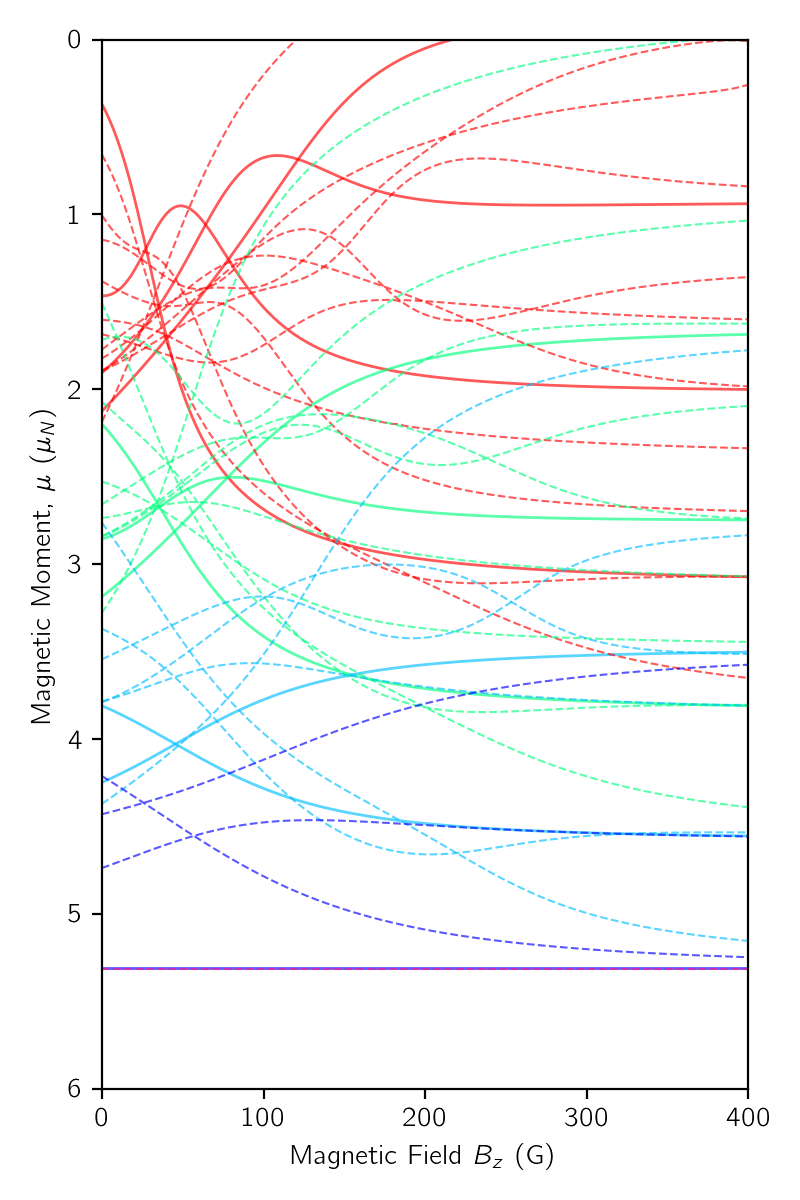

In [152]:
fig, ax = plt.subplots(figsize=(4,6))


ax.set_xlim(0,400)
ax.set_ylim(6,0)
ax.set_xlabel('Magnetic Field $B_z$ (G)')
ax.set_ylabel('Magnetic Moment, $\mu$ $(\mu_N)$')

five_col = [
'#ff0000',
'#00ff7f',
'#00bfff',
'#0000ff',
'#ff1493'
]

states_to_plot = []
for N in range(0,2):
    F = round(N + I1 + I2)
    for MF in range(max(-F,2),min(F+1,7)):
        for di in range(label_degeneracy(N,MF)):
            states_to_plot.append((N,MF,di))

for state_label in states_to_plot:
    lw=1
    col = five_col[state_label[1]-2]
    ls = 'solid'
    if state_label[0] != 0:
        ls = 'dashed'
        lw=0.75
        
    index = label_to_state_no(*state_label)
    ax.plot(B/GAUSS, MAGNETIC_MOMENTS[:,index]/muN,linestyle=ls, color=col, alpha=0.65,linewidth=lw);
    

# find all triplets 
# for i,(la,lb,lc) in enumerate(ordered_states[:100]):
#     if la[0] == 1 and lb[0]==0 and lc[0]==0:
#         if la[1]<=6 and la[1]>=2 and lb[1]<=6 and lb[1]>=2 and lc[1]<=6 and lc[1]>=2:
#             fid = ordered_fidelities[i]
#             dev = ordered_deviations[i]/muN
#             if fid < 0.2 or dev > 0.1:
#                 continue
#             x = B[ordered_B[i]]/GAUSS
#             state_indices = np.array([label_to_state_no(*la),label_to_state_no(*lb),label_to_state_no(*lc)])
#             y = np.sum(np.abs(MAGNETIC_MOMENTS[ordered_B[i],state_indices]))/(3*muN)
#             ax.plot([x],[y], 'o', mfc='none',markersize=2,c='black')
#             ax.text(x+5,y,f'f={fid:.3f},d={dev:.3f}',fontsize=8,va='bottom',ha='left',picker=True)
#             ax.text(x+5,y,r'$|{},{}\rangle_{} |{},{}\rangle_{} |{},{}\rangle_{}$'.format(*la,*lb,*lc),fontsize=8,va='top',ha='left',picker=True)

# fig.savefig('../images/3-level-qubit-all-coincidences.pdf')

# Find best state Pi-pulse paths

In [457]:
initial_index_5 = label_to_state_no(0,5,0)
initial_index_4 = label_to_state_no(0,4,1)

cumulative_fidelity_5 = np.zeros((B_STEPS,N_STATES))
predecessor_fidelity_5 = np.zeros((B_STEPS,N_STATES),dtype=int)
cumulative_fidelity_4 = np.zeros((B_STEPS,N_STATES))
predecessor_fidelity_4 = np.zeros((B_STEPS,N_STATES),dtype=int)

for bi in range(B_STEPS):
    considered_matrix = UNPOLARISED_PAIR_FIDELITIES[:,:,bi]
    sparse_graph = csgraph.csgraph_from_dense(-np.log(considered_matrix), null_value=np.inf) # Expecting div 0 warning, this is fine
    (dist5,dist4),(pred5,pred4) = csgraph.shortest_path(sparse_graph,return_predecessors=True,directed=False,indices=(initial_index_5,initial_index_4))
    
    cumulative_fidelity_5[bi]=dist5
    cumulative_fidelity_4[bi]=dist4
    
    predecessor_fidelity_5[bi]=pred5
    predecessor_fidelity_4[bi]=pred4

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_71758/2927724474.py:11: RuntimeWarning: divide by zero encountered in log
  sparse_graph = csgraph.csgraph_from_dense(-np.log(considered_matrix), null_value=np.inf) # Expecting div 0 warning, this is fine


# Generic Optimisation Routine

In [638]:
def maximise_fid_dev(possibilities,loop=False,plot=True,required_crossing=None,max_bi=B_STEPS,table_len=9,ignore_small_deviation=False,rate_distance=True):
    print(len(possibilities), "combinations to consider")
    possibilities_indices = np.array([np.array([label_to_state_no(*label) for label in possibility]) for possibility in possibilities])
    n_waves = len(possibilities[0]) - 1 # NOTE: assumes paths are the same length
    
    # Find best B for minimum dipole deviation
    best_deviation = np.ones((len(possibilities)),dtype=np.double)
    best_b_index = np.ones((len(possibilities)),dtype=int)
    for i, desired_indices in enumerate(possibilities_indices):
        all_moments = MAGNETIC_MOMENTS[:max_bi,desired_indices]
        if required_crossing is not None:
            required_deviation = all_moments[:,required_crossing[0]]-all_moments[:,required_crossing[1]]
            sign_changes = np.where(np.diff(np.sign(required_deviation)))[0]
            mask = np.ones(max_bi, dtype=bool)
            mask[sign_changes] = False
            all_moments[mask,0] = 1e10
        max_moment = np.amax(all_moments,axis=1)
        min_moment = np.amin(all_moments,axis=1)
        deviation = max_moment - min_moment
        min_diff_loc = np.argmin(deviation)
        min_diff = deviation[min_diff_loc]
        best_deviation[i] = np.abs(min_diff/muN)
        best_b_index[i] = min_diff_loc

    # Simulate microwave transfers to find fidelity *within structure*
    top_fidelities_unpol = np.zeros(len(possibilities),dtype=np.double)
    top_fidelities_pol = np.zeros(len(possibilities),dtype=np.double)
    for i, desired_indices in enumerate(possibilities_indices):
        at_Bi = best_b_index[i]
        unpol_p = 1
        pol_p = 1
        for n in range(n_waves):
            unpol_p *= UNPOLARISED_PAIR_FIDELITIES[desired_indices[n],desired_indices[n+1],at_Bi]
            pol_p *= POLARISED_PAIR_FIDELITIES[desired_indices[n],desired_indices[n+1],at_Bi]
        if loop:
            unpol_p *= UNPOLARISED_PAIR_FIDELITIES[desired_indices[0],desired_indices[-1],at_Bi]
            pol_p *= POLARISED_PAIR_FIDELITIES[desired_indices[0],desired_indices[-1],at_Bi]
        top_fidelities_unpol[i] = unpol_p
        top_fidelities_pol[i] = pol_p
        
    # Find path to get there from (0,5,0) or (0,4,1)
    top_distance = np.zeros(len(possibilities),dtype=np.double)
    top_distance_start = np.zeros(len(possibilities),dtype=int)
    top_distance_initial_5 = np.full(len(possibilities), True)
    for i, desired_indices in enumerate(possibilities_indices):
        at_Bi = best_b_index[i]
        best_5 = cumulative_fidelity_5[at_Bi,desired_indices]
        best_5_index = np.argmin(best_5)
        best_5_value = best_5[best_5_index]
        
        best_4 = cumulative_fidelity_4[at_Bi,desired_indices]
        best_4_index = np.argmin(best_4)
        best_4_value = best_4[best_4_index]

        if best_5_value > best_4_value: # 4 is best
            top_distance[i] = np.exp(-best_4_value)
            top_distance_start[i] = best_4_index
            top_distance_initial_5[i] = False
        else: # 5 is best
            top_distance[i] = np.exp(-best_5_value)
            top_distance_start[i] = best_5_index

    # Rank state combinations
    rating = np.zeros(len(possibilities),dtype=np.double)
    for i, focus_state in enumerate(possibilities):
        dev = best_deviation[i]
        fid_unpol = top_fidelities_unpol[i]
        fid_pol = top_fidelities_pol[i]
        dist_unpol = top_distance[i]
        rating[i] = fidelity(fid_unpol,d=3)*fidelity(fid_pol,d=6)
        if rate_distance:
            rating[i] *= fidelity(dist_unpol,d=4)*(dist_unpol>0.95)
        if ignore_small_deviation:
            rating[i] *= dev<0.001
        else:
            rating[i] *= -np.log(dev+1e-5)
        

    order = (-rating).argsort()

    ordered_states = possibilities[order]
    ordered_B = best_b_index[order]
    ordered_fidelities_pol = top_fidelities_pol[order]
    ordered_fidelities_unpol = top_fidelities_unpol[order]
    ordered_deviations = best_deviation[order]
    ordered_distances = top_distance[order]
    ordered_distance_start = top_distance_start[order]
    ordered_distance_initial_5 = top_distance_initial_5[order]
    ordered_rating = rating[order]
    
    # Create Table
    headers = ['States', 'Mag. Field(G)', 'MagDipDev(u)', 'UnPol-Fid', 'Pol-Fid', 'UnPol-Dist','Rating','Path']
    data = []
    for i in range(table_len):
        state_labels = ordered_states[i]
        state_numbers = np.array([label_to_state_no(*state_label) for state_label in ordered_states[i]])
        this_magnetic_field = B[ordered_B[i]]
        this_max_dev = np.abs(ordered_deviations[i])
        this_fidelity_pol = ordered_fidelities_pol[i]
        this_fidelity_unpol = ordered_fidelities_unpol[i]
        this_distance = ordered_distances[i]
        this_distance_start = ordered_distance_start[i]
        this_distance_initial_5 = ordered_distance_initial_5[i]
        this_rating = ordered_rating[i]
        
        current_back = state_numbers[this_distance_start]
        start_index = initial_index_5 if this_distance_initial_5 else initial_index_4
        initial_label = LABELS[current_back]
        predecessor_list = predecessor_fidelity_5[ordered_B[i]] if this_distance_initial_5 else predecessor_fidelity_4[ordered_B[i]]
        path=f"({initial_label[0]},{initial_label[1]},{initial_label[2]})"
        path = [initial_label]
        while current_back != start_index:
            current_back = predecessor_list[current_back]
            path.append(LABELS[current_back])
        if len(path) < 5:
            path_string = "<".join([f"({label[0]},{label[1]},{label[2]})" for label in path])
        else:
            path_string = "<".join([f"({label[0]},{label[1]},{label[2]})" for label in path[:2]])
            path_string += f"<..(+{len(path)-4})..<"
            path_string += "<".join([f"({label[0]},{label[1]},{label[2]})" for label in path[len(path)-2:]])
        states_string = ",".join([f"({label[0]},{label[1]},{label[2]})" for label in state_labels])
        data.append([states_string,this_magnetic_field/GAUSS,this_max_dev,this_fidelity_unpol,this_fidelity_pol,this_distance,this_rating,path_string])
    print(tabulate(data, headers=headers,tablefmt="fancy_grid"))
    
    # Show magnetic moments plot
    if plot:
        fig, axs = plt.subplots(4,4,figsize=(8,8),dpi=100,sharex=True,constrained_layout=True) #,sharey=True
        i=0
        for axh in axs:
            for ax in axh:
                state_labels = ordered_states[i]
                state_numbers = np.array([label_to_state_no(*state_label) for state_label in ordered_states[i]])
                ax.set_xlim(0,B_MAX/GAUSS)
                at_mm = MAGNETIC_MOMENTS[ordered_B[i],state_numbers[0]]/muN
                ax.set_ylim(at_mm-1,at_mm+1)
                # ax.set_yticks(np.arange(-4,4,0.5))
                ax.plot(B/GAUSS,MAGNETIC_MOMENTS[:,state_numbers]/muN, alpha=1,linewidth=1.5,zorder=1);
                ax.axvline(x=min(B[ordered_B[i]]/GAUSS,B_MAX/GAUSS*0.98), dashes=(3, 2), color='k', linewidth=1.5,alpha=0.3,zorder=0)
                this_fidelity = ordered_fidelities_unpol[i]
                this_distance = ordered_distances[i]
                max_dev = np.abs(ordered_deviations[i])
                states_string = ""
                for si, label in enumerate(state_labels):
                    states_string += r'$|{},{}\rangle_{{{}}}$'.format(*label)
                ax.set_title(f'd={max_dev:.4f} f={this_fidelity:.4f} \n {states_string}')
                i+=1

        fig.supxlabel( 'Magnetic Field $B_z$ (G)')
        fig.supylabel('Magnetic Moment $\mu$ $(\mu_N)$')
        # fig.savefig('../images/magnetic-dipole-coincides-storage-qubit.pdf')

# Robust Storage Bit Optimisation

In [639]:
# Find all possible combinations
# two states in N, one in N+-1

possibilities = []
for N1 in [1]:#range(0,N_MAX+1): #[1]:#
    for N2 in [2]:#[N1-1,N1+1]: #[0]:#
        if N2 < 0 or N2 > N_MAX:
            continue
        F1 = round(N1+I1+I2)
        F2 = round(N2+I1+I2)
        for MF1 in [2,3,4,5]+([6] if N1>0 else []):#range(-F1,F1+1,1):
            for p1 in [-1,0,1]:
                for p2 in [-1,0,1]:
                    if MF1+p1 > F2 or MF1+p1 < -F2 or MF1+p2 > F2 or MF1+p2 < -F2:
                        continue
                    MF2a = MF1+p1
                    MF2b = MF1+p2
                    if MF2a < MF2b:
                        continue
                    for i in range(label_degeneracy(N1,MF1)):
                        for j in range(label_degeneracy(N2,MF2a)):
                            for k in range(label_degeneracy(N2,MF2b)):
                                if MF2a == MF2b and j <= k:
                                    continue
                                possibilities.append([(N2,MF2a,j),(N1,MF1,i),(N2,MF2b,k)])
possibilities = np.array(possibilities)

24023 combinations to consider
╒═══════════════════════════╤═════════════════╤════════════════╤═════════════╤═══════════╤══════════════╤══════════╤═════════════════════════════════╕
│ States                    │   Mag. Field(G) │   MagDipDev(u) │   UnPol-Fid │   Pol-Fid │   UnPol-Dist │   Rating │ Path                            │
╞═══════════════════════════╪═════════════════╪════════════════╪═════════════╪═══════════╪══════════════╪══════════╪═════════════════════════════════╡
│ (2,6,0),(1,5,0),(2,4,0)   │         635.271 │     0.00151548 │    0.964144 │  1        │     0.999791 │ 194.771  │ (1,5,0)<(0,5,0)                 │
├───────────────────────────┼─────────────────┼────────────────┼─────────────┼───────────┼──────────────┼──────────┼─────────────────────────────────┤
│ (2,6,0),(1,5,0),(2,5,0)   │         977.956 │     0.00490355 │    0.980452 │  1        │     0.999796 │ 189.235  │ (1,5,0)<(0,5,0)                 │
├───────────────────────────┼─────────────────┼────────────────

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


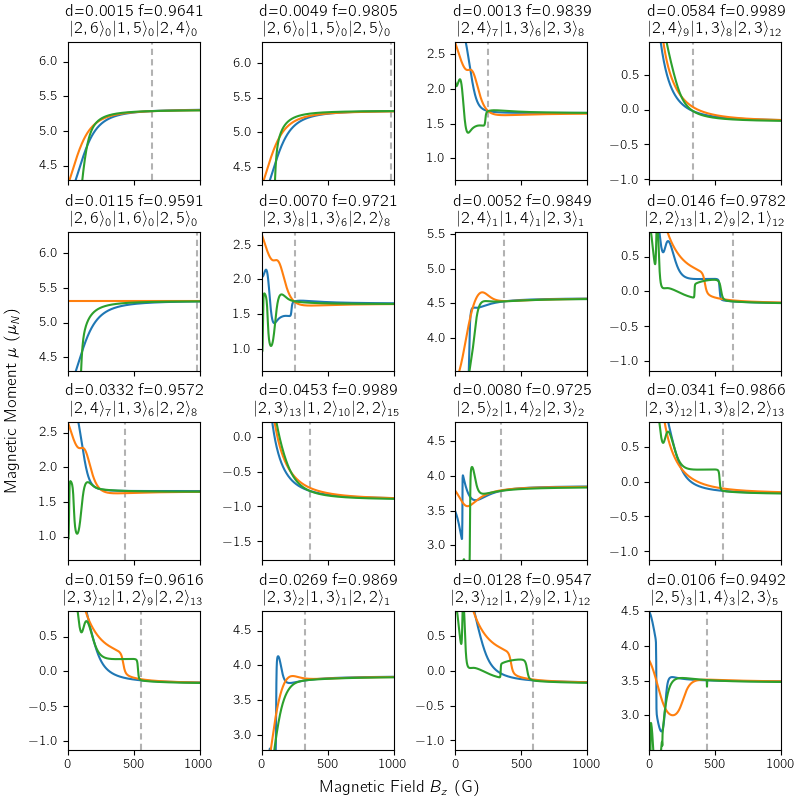

In [635]:
maximise_fid_dev(possibilities,loop=False,required_crossing=[0,2])

# 4-state loop Optimisation

In [640]:
# Find all possible combinations
polarisations = []
for p1 in [-1,0,1]:
    for p2 in [-1,0,1]:
        for p3 in [-1,0,1]:
            for p4 in [-1,0,1]:
                if p1+p2+p3+p4 == 0:
                    polarisations.append((p1,p2,p3,p4))

state_mfs = []                    
for base_mf in range(0,5+1):
    for p1,p2,p3,_ in polarisations:
        state_mfs.append((base_mf,base_mf+p1,base_mf+p1+p2,base_mf+p1+p2+p3))

states = []
for state_mf in state_mfs:
    for i in range(label_degeneracy(0,state_mf[0])):
        for j in range(label_degeneracy(1,state_mf[1])):
            for k in range(label_degeneracy(2,state_mf[2])):
                for l in range(label_degeneracy(1,state_mf[3])):
                    if (state_mf[1]<state_mf[3]) or (state_mf[1]==state_mf[3] and j<=l):
                        continue
                    states.append([(0,state_mf[0],i),(1,state_mf[1],j),(2,state_mf[2],k),(1,state_mf[3],l)])
                    
states=np.array(states)

302671 combinations to consider
╒═══════════════════════════════════╤═════════════════╤════════════════╤═════════════╤═══════════╤══════════════╤══════════╤════════════════════════════════════════════╕
│ States                            │   Mag. Field(G) │   MagDipDev(u) │   UnPol-Fid │   Pol-Fid │   UnPol-Dist │   Rating │ Path                                       │
╞═══════════════════════════════════╪═════════════════╪════════════════╪═════════════╪═══════════╪══════════════╪══════════╪════════════════════════════════════════════╡
│ (0,2,0),(1,3,3),(2,2,3),(1,2,1)   │         448.898 │     0.0073729  │    0.976715 │  0.999997 │  0.795217    │  42.5669 │ (0,2,0)<(1,1,9)<..(+7)..<(1,4,0)<(0,5,0)   │
├───────────────────────────────────┼─────────────────┼────────────────┼─────────────┼───────────┼──────────────┼──────────┼────────────────────────────────────────────┤
│ (0,1,0),(1,2,4),(2,1,3),(1,1,1)   │         422.846 │     0.00734313 │    0.976489 │  0.999996 │  0.78796     │  42.

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


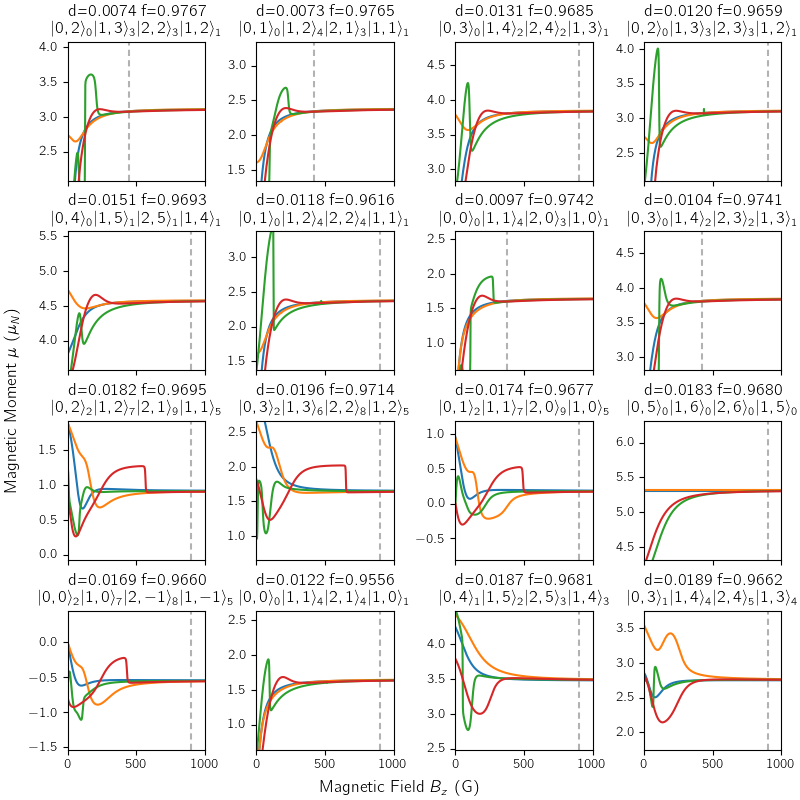

In [644]:
maximise_fid_dev(states,loop=True,table_len=15,rate_distance=False,max_bi=int(B_STEPS*0.9))

# 2-state

In [645]:
states=[]
for N1 in range(0,N_MAX): #[1]:#
    N2=N1+1
    F1 = round(N1+I1+I2)
    for MF1 in range(F1):
        for MF2 in [MF1-1,MF1,MF1+1]:
            for i in range(label_degeneracy(N1,MF1)):
                for j in range(label_degeneracy(N2,MF2)):
                    states.append([(N1,MF1,i),(N2,MF2,j)])           
states=np.array(states)

3050 combinations to consider
╒═══════════════════╤═════════════════╤════════════════╤═════════════╤═══════════╤══════════════╤══════════╤════════════════════════════════════════════╕
│ States            │   Mag. Field(G) │   MagDipDev(u) │   UnPol-Fid │   Pol-Fid │   UnPol-Dist │   Rating │ Path                                       │
╞═══════════════════╪═════════════════╪════════════════╪═════════════╪═══════════╪══════════════╪══════════╪════════════════════════════════════════════╡
│ (1,3,2),(2,2,2)   │        1000     │    0.00042999  │    0.999925 │         1 │  0.983871    │  17.8113 │ (1,3,2)<(2,3,5)<(1,4,3)<(0,4,1)            │
├───────────────────┼─────────────────┼────────────────┼─────────────┼───────────┼──────────────┼──────────┼────────────────────────────────────────────┤
│ (1,2,4),(2,3,6)   │         476.954 │    3.84987e-06 │    0.999933 │         1 │  0.52126     │  17.7962 │ (1,2,4)<(0,1,0)<..(+12)..<(1,3,2)<(0,4,1)  │
├───────────────────┼─────────────────┼───────

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


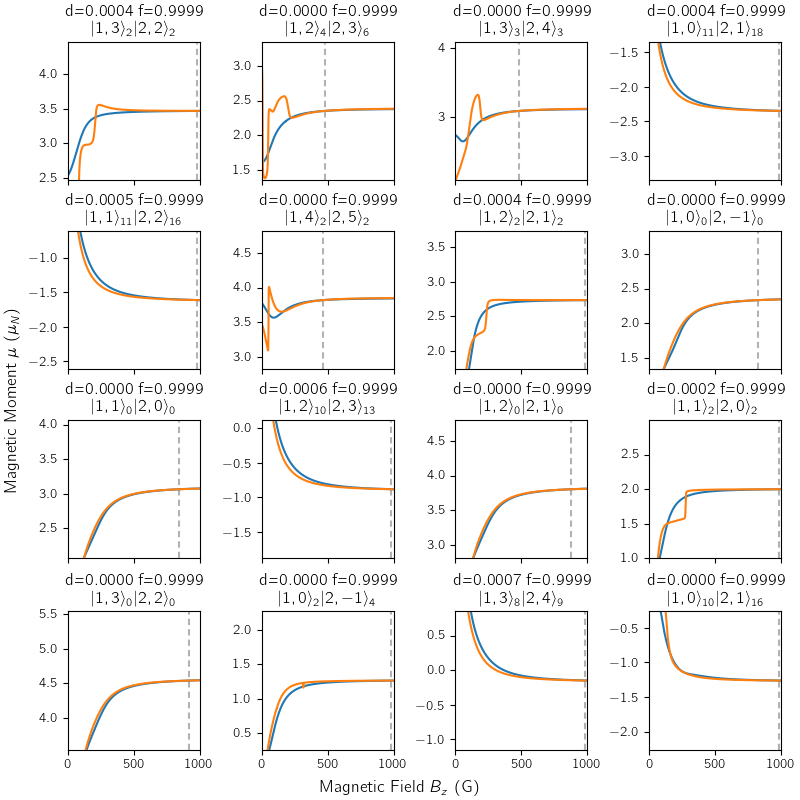

In [646]:
maximise_fid_dev(states,table_len=9,rate_distance=False,ignore_small_deviation=True)

# 3-state

In [592]:
states=[]
N1=0
N2=1
N3=2
F1 = round(N1+I1+I2)
for MF1 in range(F1):
    for MF2 in [MF1-1,MF1,MF1+1]:
        for MF3 in [MF2-1,MF2,MF2+1]:
            for i in range(label_degeneracy(N1,MF1)):
                for j in range(label_degeneracy(N2,MF2)):
                    for k in range(label_degeneracy(N3,MF3)):
                        states.append([(N1,MF1,i),(N2,MF2,j),(N3,MF3,k)])           
states=np.array(states)

26705 combinations to consider
╒═══════════════════════╤═════════════════╤════════════════╤═════════════╤═══════════╤══════════════╤══════════╤══════════════════════════════════════╕
│ States                │   Mag. Field(G) │   MagDipDev(u) │   UnPol-Fid │   Pol-Fid │   UnPol-Dist │   Rating │ Path                                 │
╞═══════════════════════╪═════════════════╪════════════════╪═════════════╪═══════════╪══════════════╪══════════╪══════════════════════════════════════╡
│ (0,4,1)(1,4,3)(2,4,4) │        1000     │    0.0104884   │    0.99714  │  1        │     1        │  263.834 │ (0,4,1)                              │
├───────────────────────┼─────────────────┼────────────────┼─────────────┼───────────┼──────────────┼──────────┼──────────────────────────────────────┤
│ (0,3,0)(1,4,2)(2,5,2) │         164.329 │    0.000406959 │    0.999565 │  0.999986 │     0.989595 │  210.865 │ (0,3,0)(1,2,9)(2,3,12)(1,3,8)(0,4,1) │
├───────────────────────┼─────────────────┼──────────────

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


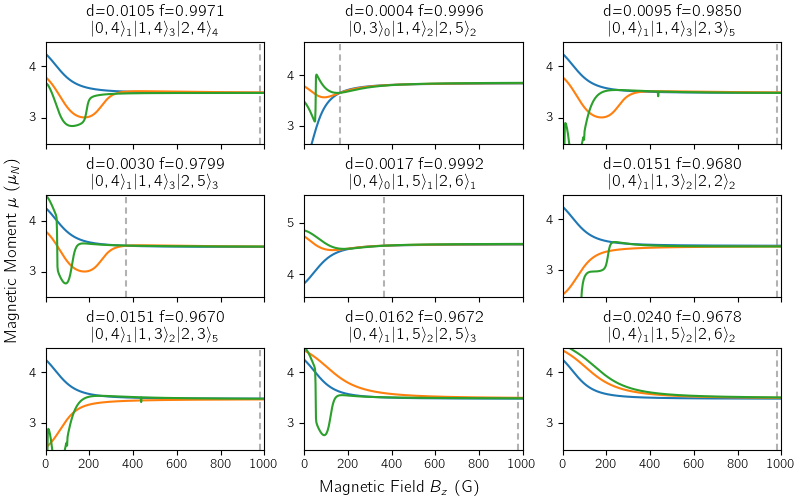

In [594]:
maximise_fid_dev(states,table_len=9)